# Domain Resizing

So far, we have considered $k$-local Hamiltonians, i.e. those in which each term of the Hamiltonian acts on at most $k$ neigboring qubits. The unitaries that the algorithm produces to emulate the ITE are all unitaries acting on exactly the same qubits that each Hamiltonian term $h[m]$ acts on.

Now, assuming a linear qubit topology, we will produce unitaries acting on a domain size $D$ around the support of each $h[m]$, i.e. centered at the qubits $h[m]$ acts on, the unitary will act on qubits a within a diameter of $D$ from the center. 

**TODO:**
1. Write a function that calculates what k is for the Hamiltonian
2. If k is even, only accept even D, if odd only accept odd D.
3. Modify `update_alist` to accept a parameter D, and do necessary checks to ensure only a valid D is passed prior to the function call.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

import time
from y_qite import y_propagate, y_log_qite_run
from qite import propagate, log_qite_run

from helper import *
from ideal_qite import ideal_energy, pauli_expectation

import time

In [34]:
def get_k(hm_list):
    '''
    Given that hm_list describes a k-local Hamiltonian on a 
    linear qubit topology, this function returns what k is.
    '''
    k = 0
    for hm in hm_list:
        range = np.max(hm[2]) - np.min(hm[2]) + 1
        if k < range:
            k = range
    return k

def valid_domain(hm_list, D, nbits):
    '''
    Checks if D is a valid domain size for a k-local Hamiltonian
    on a linear qubit topology
    '''
    # domain size is restrited to the number of qubits
    if D > nbits:
        return False
    
    k = get_k(hm_list)
    # Only a valid domain size if D and k have the same parity
    return k%2 == D%2

def print_hamiltonian(hm_list):
    print('H is a {}-local Hamiltonian'.format(get_k(hm_list)))
    term = 0
    for hm in hm_list:
        term += 1
        print('Term {}:'.format(term))
        for j in range(len(hm[0])):
            nactive = len(hm[2])
            pstring = int_to_base(hm[0][j],4,nactive)
            for i in range(nactive):
                if pstring[i] == 0:
                    pstring[i] = 'I'
                else:
                    pstring[i] = chr(ord('X') + pstring[i] - 1)
            print('\t({0:.2f} {1} {2:.2f}i)'.format(hm[1][j].real, '+-'[int(hm[1][j].imag) < 0], abs(hm[1][j].imag)),end=' ',flush=True)
            for i in range(nactive):
                print('{}_{}'.format(pstring[i],hm[2][i]),end=' ',flush=True)
            if j < len(hm[0])-1:
                print('+')
            else:
                print()

def extended_domain(hm, k, D, nbits):
    '''
    Returns a list of the extended domain of a k-local Hamiltonian term hm
    with a domain size D, and nbits qubits in a linear topology
    '''
#     ex = (D-k)//2
#     _min = max(np.min(hm[2]) - ex, 0)
#     _max = min(np.max(hm[2])+1 + ex, nbits)
#     return list(range(_min,_max))
    if (np.max(hm[2]) - np.min(hm[2]) + 1) % 2 == 0:
        if D%2 == 1:
            D = D-1
        center = (np.min(hm[2]) + np.max(hm[2])) // 2
        radius = D//2
        _min = max( center+1 - radius ,0 )
        _max = min( center + radius, nbits )
        return list(range(_min, _max+1))
    else:
        if D%2 == 0:
            D = D-1
        center = (np.min(hm[2]) + np.max(hm[2])) // 2
        radius = D//2
        _min = max( center-radius, 0 )
        _max = min( center+radius, nbits )
        return list(range(_min,_max+1))
            

# hm_list = []
# hm_list.append([ [3+4*1, 1+3*4], [0.5+0.j, 0.5+0.j], [2,3]])
# hm_list.append([ [2], [0.33+0.j], [1]])

nbits = 6
hm_list = long_range_heisenberg(nbits,[0.1,0.2,0.3])

k = get_k(hm_list)

Ds = np.arange(1,nbits+1)

# x = [1,3]
# k = get_k([[[],[],x]])
# D=2
# print(x,'->',extended_domain([[],[],x], k, D, nbits))


print_hamiltonian(hm_list)
print('\nChecking Domain Validities:\n')
for D in Ds:
    valid_d = valid_domain(hm_list,D,nbits)
    print('D={} is a valid domain size?'.format(D),valid_d,end=': ',flush=True)
    if not valid_d:
        if D > nbits:
            print('D > nbits')
        elif k > D:
            print('k > D')
        elif k%2 != D%2:
            print('k and D have opposite parity')
    else:
        print('\n\tQubits each term acts on:')
        for hm in hm_list:
#             ex = (D - k) //2
#             print('\t\t',np.arange( np.min(hm[2])-ex, np.max(hm[2])+ex + 1 ))
            print('\t\t',hm[2],'->',extended_domain(hm, k, D, nbits))

H is a 6-local Hamiltonian
Term 1:
	(0.05 + 0.00i) X_0 X_1 +
	(0.10 + 0.00i) Y_0 Y_1 +
	(0.15 + 0.00i) Z_0 Z_1 
Term 2:
	(0.03 + 0.00i) X_0 X_2 +
	(0.07 + 0.00i) Y_0 Y_2 +
	(0.10 + 0.00i) Z_0 Z_2 
Term 3:
	(0.03 + 0.00i) X_0 X_3 +
	(0.05 + 0.00i) Y_0 Y_3 +
	(0.07 + 0.00i) Z_0 Z_3 
Term 4:
	(0.02 + 0.00i) X_0 X_4 +
	(0.04 + 0.00i) Y_0 Y_4 +
	(0.06 + 0.00i) Z_0 Z_4 
Term 5:
	(0.02 + 0.00i) X_0 X_5 +
	(0.03 + 0.00i) Y_0 Y_5 +
	(0.05 + 0.00i) Z_0 Z_5 
Term 6:
	(0.05 + 0.00i) X_1 X_2 +
	(0.10 + 0.00i) Y_1 Y_2 +
	(0.15 + 0.00i) Z_1 Z_2 
Term 7:
	(0.03 + 0.00i) X_1 X_3 +
	(0.07 + 0.00i) Y_1 Y_3 +
	(0.10 + 0.00i) Z_1 Z_3 
Term 8:
	(0.03 + 0.00i) X_1 X_4 +
	(0.05 + 0.00i) Y_1 Y_4 +
	(0.07 + 0.00i) Z_1 Z_4 
Term 9:
	(0.02 + 0.00i) X_1 X_5 +
	(0.04 + 0.00i) Y_1 Y_5 +
	(0.06 + 0.00i) Z_1 Z_5 
Term 10:
	(0.05 + 0.00i) X_2 X_3 +
	(0.10 + 0.00i) Y_2 Y_3 +
	(0.15 + 0.00i) Z_2 Z_3 
Term 11:
	(0.03 + 0.00i) X_2 X_4 +
	(0.07 + 0.00i) Y_2 Y_4 +
	(0.10 + 0.00i) Z_2 Z_4 
Term 12:
	(0.03 + 0.00i) X_2 X_5 +
	

In [3]:
def ideal_tomography_ext_domain(hm, k, D, alist, qbits, nbits, init_sv, odd_y_flag):
    domain = extended_domain(hm, k, D, nbits)
    nactive = len(domain)
    
    if odd_y_flag:
        odd_ys = odd_y_pauli_strings(nactive)
        nops = len(odd_ys)
        
        keys = []
        
        for j in hm[0]:
            if not(j in keys):
                keys.append(j)
        
        for i in odd_ys:
            for j in odd_ys:
                p,c = pauli_string_prod(i,j,nactive)
                if not (p in keys):
                    keys.append(p)
            for j in hm[0]:
                p,c = pauli_string_prod(i,j,nactive)
                if not (p in keys):
                    keys.append(p)
        
        sigma_expectation = {}
        for key in keys:
            qc = QuantumCircuit(nbits, nbits)
            y_propagate(qc, alist)
            psi = init_sv.evolve(qc)
            sigma_expectation[key] = pauli_expectation(psi, key, qbits)
        
        return sigma_expectation, psi
    else:
        nops=  4**nactive
        
        sigma_expectation = np.zeros(nops,dtype=float)
        sigma_expectation[0] = 1.0
        
        qc = QuantumCircuit(nbits)
        propagate(qc,alist)

        psi = init_sv.evolve(qc)
        
        for i in range(1,nops):
            sigma_expectation[i] = pauli_expectation(psi, i, qbits)
        return sigma_expectation, psi

In [4]:
def ext_domain_pauli(p, active, domain):
    pstring = int_to_base(p,4,len(active))
    new_pstring = [0] * len(domain)
    for i in range(len(active)):
        if active[i] not in domain:
            print('Error Occured in ext_domain_pauli:')
            print('active:', active)
            print('domain:',domain)
            print('active[{}] not in domain'.format(i))
        ind = domain.index(active[i])
        new_pstring[ind] = pstring[i]
    return base_to_int(new_pstring, 4)

In [5]:
active = [0,3]
k = get_k([[[],[],active]])
D = k
nbits = 6
print('k={}, D={}, nbits={}'.format(k,D,nbits))

if valid_domain([ [[],[],active] ], D, nbits):
    domain = extended_domain([[],[],active], k, D, nbits)

    print('active:',active)
    print('domain:',domain)

    p = 3+4*1
    print('p:',p)
    pstring = int_to_base(p,4,len(active))
    print('pstring:',pstring)

    # new_pstring = [0] * len(domain)
    # print('new_pstring:', new_pstring)

    # for i in range(len(active)):
    #     ind = domain.index(active[i])
    #     print('index of {} in domain is {}'.format(active[i],ind))
    #     new_pstring[ind] = pstring[i]
    # print(new_pstring)

    new_p = ext_domain_pauli(3+4*1, active, domain)
    print('new_p:', new_p)
    new_pstring = int_to_base(new_p,4,len(domain))
    print('new_pstring:',new_pstring)
else:
    print('Invalid Domain')

k=4, D=4, nbits=6
active: [0, 3]
domain: [0, 1, 2, 3]
p: 7
pstring: [3, 1]
new_p: 67
new_pstring: [3, 0, 0, 1]


In [6]:
def update_alist_ext_domain(sigma_expectation, alist, db, delta, hm, k, D, nbits, scale, odd_y_flag):
    domain = extended_domain(hm, k, D, nbits)
    ndomain = len(domain)
    # number of qubits that the term acts on
    active = hm[2]
    nactive = len(hm[2])
    # number of pauli terms present in hm
    nterms = len(hm[0])
    
    if odd_y_flag:
        odd_ys = odd_y_pauli_strings(ndomain)
        nops = len(odd_ys)

        # Step 1: Obtain S matrix:
        # S[I,J] = <psi| sigma_I sigma_J |psi>
        S = np.zeros([nops,nops],dtype=complex)
        for i in range(nops):
            for j in range(nops):
                p,c_ = pauli_string_prod(odd_ys[i], odd_ys[j], ndomain)
                S[i,j] = sigma_expectation[p] * c_

        # Step 2: Obtain b vector
        b = np.zeros(nops, dtype=complex)
        c = 1

        for i in range(nterms):
            c -= scale * db * hm[1][i] * sigma_expectation[ext_domain_pauli(hm[0][i],active,domain)]
        c = np.sqrt(c)

        for k in range(nops):
            # This part not needed since it will always be real
            # b[k] += (1/c - 1) * sigma_expectation[odd_ys[k]] / db
            for j in range(nterms):
                p,c_ = pauli_string_prod(odd_ys[k], ext_domain_pauli(hm[0][j],active,domain), ndomain)
                b[k] -= hm[1][j] * c_ * sigma_expectation[p] / c
        b = -2*np.imag(b)
    else:
        nops = 4**ndomain

        # Step 1: Obtain S matrix:
        # S[I,J] = <psi| sigma_I sigma_J |psi>

        S = np.zeros([nops,nops],dtype=complex)
        for i in range(nops):
            for j in range(nops):
                p,c_ = pauli_string_prod(i,j,ndomain)
                S[i,j] = sigma_expectation[p]*c_

        # Step 2: Obtain b vector
        b = np.zeros(nops,dtype=complex)
        c = 1

        for i in range(nterms):
            c -= scale* db* hm[1][i] * sigma_expectation[ext_domain_pauli(hm[0][i],active,domain)]
        c = np.sqrt(c)

        for i in range(nops):
            # This part not needed since it will always be real
            # b[i] += ( 1/c - 1 ) * sigma_expectation[i] / db
            for j in range(nterms):
                p,c_ = pauli_string_prod(i, ext_domain_pauli(hm[0][j],active,domain), ndomain)
                b[i] -= hm[1][j] * c_ * sigma_expectation[p] / c
        b = -2*np.imag(b)

    # Step 3: Add regularizer to make sure the system can be solved
    dalpha = np.eye(nops)*delta

    # Step 4: Solve the system
    x = np.linalg.lstsq(2*np.real(S) + dalpha, -b, rcond=-1)[0]

    # Multiply by -2*db so that the appropriate rotation is applied since the rotation about 
    # sigma gates are exp(-theta/2 sigma) but we want exp(theta sigma)
    a_coefficients = -2.0*db*x
    # Append to the a coefficients
    alist.append([a_coefficients, hm[2]])

    return c

In [7]:
def ideal_qite_step_ext_domain(alist, db, delta, nbits, hm_list, k, D, init_sv, odd_y_flag):
    nterms = len(hm_list)
    
    for m in range(nterms-1):
        hm = hm_list[m]
        sigma_expectation, psi = ideal_tomography_ext_domain(hm, k, D, alist, hm[2], nbits, init_sv, odd_y_flag)
        update_alist_ext_domain(sigma_expectation, alist, db, delta, hm, k, D, nbits, 1.0, odd_y_flag)
    
    hm = hm_list[-1]
    sigma_expectation, psi = ideal_tomography_ext_domain(hm, k, D, alist, hm[2], nbits, init_sv, odd_y_flag)
    update_alist_ext_domain(sigma_expectation, alist, db, delta, hm, k, D, nbits, 2.0, odd_y_flag)
    
    for m in range(nterms-1,-1,-1):
        hm = hm_list[m]
        sigma_expectation, psi = ideal_tomography_ext_domain(hm, k, D, alist, hm[2], nbits, init_sv, odd_y_flag)
        update_alist_ext_domain(sigma_expectation, alist, db, delta, hm, k, D, nbits, 1.0, odd_y_flag)
    
    return alist, psi

In [8]:
def ideal_qite_ext_domain(db,delta,N,nbits,hm_list,D,init_sv,details=False,log=False,log_file='ideal-qite'):
    odd_y_flag = is_real_hamiltonian(hm_list)
    
    k = get_k(hm_list)
    
    if not valid_domain(hm_list, D, nbits):
        print('Error: The domain size is invalid')
        if D > nbits:
            print('D > nbits')
        elif k > D:
            print('k > D')
        elif k%2 != D%2:
            print('k and D have opposite parity')
        return None
    
    E = np.zeros(N+1,dtype=complex)
    times = np.zeros(N+1,dtype=float)
    
    states = []
    if init_sv == None:
        states.append(Statevector.from_label('0'*nbits))
    else:
        states.append(init_sv)
    
    alist = []
    
    E[0] = ideal_energy(alist, nbits, hm_list, states[0], odd_y_flag)
    
    start = 0
    end = 0
    if details:
        print('Starting QITE Loop')
    
    for i in range(1,N+1):
        if details:
            print('i={}'.format(i), end=' ', flush=True)
            start = time.time()
        
        alist,psi = ideal_qite_step_ext_domain(alist, db, delta, nbits, hm_list, k, D, init_sv, odd_y_flag)
        E[i] = ideal_energy(alist, nbits, hm_list, states[0], odd_y_flag)
        states.append(psi)
        
        if details:
            end = time.time()
            duration = end-start
            times[i] = duration
            print('Execution time: {:.2f} seconds'.format(duration))
    
    if log:
        if odd_y_flag:
            y_log_qite_run(db,delta,N,nbits,hm_list,alist,log_file)
        else:
            log_qite_run(db,delta,N,nbits,hm_list,alist,log_file)
    
    return E,times,states

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

from os import path, makedirs

# For plotting lines
colors = ['r','g','b','k','m']
markers = ['.','s','x','+','*','h','H','D','o']

In [63]:
# QITE Parameters
db = 0.1       # Size of imaginary time step
N = 30          # Number of imaginary time steps
shots = 1000    # Number of measurements taken for each circuit
delta = 0.1     # Regularizer value

# Set true if using 2nd order trotterization
_2nd_ord_flag = True

# Hamiltonian Description
nbits = 6       # Number of qubits in the full system

hm_list = []

h_name = '1D Ising - {} qubits'.format(nbits)
# Hamiltonian of the form sum<i,j>(Z_i Z_j)
for i in range(nbits-1):
    hm_list.append( [[3+3*4],[1.0+0.j],[i,i+1]] )

log_path = './qite_logs/ideal_qite{}/{}/db={:0.1f}/N={}/'.format('_2nd_ord' if _2nd_ord_flag else '',h_name,db,N)
fig_path = './figs/ideal_qite{}/{}/db={:0.1f}/N={}/'.format('_2nd_ord' if _2nd_ord_flag else '',h_name,db,N)

if not(path.exists(log_path)):
    makedirs(log_path)
if not(path.exists(fig_path)):
    makedirs(fig_path)

# Get the spectrum of H
w,v = get_spectrum(hm_list,nbits)
w = np.real(w)
w_sort_i = sorted(range(len(w)), key=lambda k: w[k])

In [ ]:
# state_label = '010101'
# for D in [2,4,6]:
#     prob_string = 'D={}, state={}'.format(D,state_label)
#     log_file = log_path + prob_string
#     fig_file = fig_path + prob_string

#     init_sv = Statevector.from_label(state_label)
#     E,times,states = ideal_qite_ext_domain(db,delta,N,nbits,hm_list,D,init_sv,details=True,log=True,log_file=log_file)
#     plot_data(E,states, prob_string, fig_file,prob_flag=False)

Starting QITE Loop
i=1 Execution time: 0.12 seconds
i=2 Execution time: 0.16 seconds
i=3 Execution time: 0.20 seconds
i=4 Execution time: 0.25 seconds
i=5 Execution time: 0.29 seconds
i=6 Execution time: 0.33 seconds
i=7 Execution time: 0.37 seconds
i=8 Execution time: 0.42 seconds
i=9 Execution time: 0.45 seconds
i=10 Execution time: 0.55 seconds
i=11 Execution time: 0.55 seconds
i=12 Execution time: 0.71 seconds
i=13 Execution time: 0.69 seconds
i=14 Execution time: 0.74 seconds
i=15 Execution time: 0.74 seconds
i=16 Execution time: 0.76 seconds
i=17 Execution time: 0.79 seconds
i=18 Execution time: 0.84 seconds
i=19 Execution time: 0.89 seconds
i=20 Execution time: 0.94 seconds
i=21 Execution time: 0.98 seconds
i=22 Execution time: 1.00 seconds
i=23 Execution time: 1.04 seconds
i=24 Execution time: 1.09 seconds
i=25 Execution time: 1.13 seconds
i=26 Execution time: 1.16 seconds
i=27 Execution time: 1.20 seconds
i=28 Execution time: 1.25 seconds
i=29 Execution time: 1.29 seconds
i=30

C:\Users\swaga\miniconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Execution time: 3.38 seconds
i=2 Execution time: 3.43 seconds
i=3 Execution time: 4.01 seconds
i=4 Execution time: 4.34 seconds
i=5 Execution time: 4.89 seconds
i=6 Execution time: 5.39 seconds
i=7 Execution time: 5.84 seconds
i=8 Execution time: 6.25 seconds
i=9 Execution time: 6.68 seconds
i=10 Execution time: 7.19 seconds
i=11 Execution time: 7.68 seconds
i=12 Execution time: 8.15 seconds
i=13 Execution time: 8.58 seconds
i=14 Execution time: 9.09 seconds
i=15 Execution time: 9.74 seconds
i=16 Execution time: 10.13 seconds
i=17 Execution time: 10.58 seconds
i=18 Execution time: 10.97 seconds
i=19 Execution time: 11.57 seconds
i=20 Execution time: 12.16 seconds
i=21 Execution time: 12.36 seconds
i=22 Execution time: 12.84 seconds
i=23 Execution time: 13.50 seconds
i=24 Execution time: 13.99 seconds
i=25 Execution time: 14.13 seconds
i=26 Execution time: 14.59 seconds
i=27 Execution time: 15.12 seconds
i=28 Execution time: 15.65 seconds
i=29 Execution time: 16.32 seconds
i=30 Executio

C:\Users\swaga\miniconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


C:\Users\swaga\miniconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 432x288 with 0 Axes>

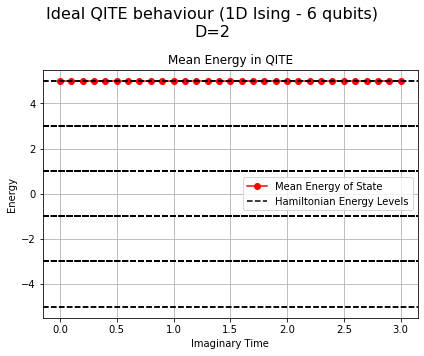

In [17]:
# plot_data(E,states, prob_string, fig_file,prob_flag=False)

# Heisenberg Model:
$\hat{\textbf{S}}_i$ is a spin vector for the $i$-th qubit:
$$\hat{\textbf{S}}_i = S_{i,x} \sigma_i^x \hat{\textbf{x}} + S_{i,y} \sigma_i^y \hat{\textbf{y}} + S_{i,z} \sigma_i^z \hat{\textbf{z}}$$

## Short Range 1-D Heisenberg Model
$$
\begin{aligned}
\hat{H} &= \sum_{\langle i,j\rangle} \hat{\textbf{S}}_i \cdot \hat{\textbf{S}}_j \\
&= S_{i,x}S_{j,x}\sigma_i^x\sigma_j^x + 
S_{i,y}S_{j,y}\sigma_i^y\sigma_j^y
+ S_{i,z}S_{j,z}\sigma_i^z\sigma_j^z \\
&= \sum_{\langle i,j\rangle} J_x X_i X_j + J_y Y_i Y_j + J_z Z_i Z_j
\end{aligned}
$$

I'm not sure why, but The $J$ terms seem to be constant over the sum instead of dependent on $i,j$.

## Short Range 1-D Heisenberg Model in the presence of a field
$$ \hat{H} = J\sum_{\langle i,j\rangle} \hat{\textbf{S}}_i\cdot\hat{\textbf{S}}_j + B \sum_i Z_i$$

## Long Range 1-D Heisenberg Model
$$\hat{H} = \sum_{i\neq j} \frac{1}{|i-j|+1} \hat{\textbf{S}}_i\cdot\hat{\textbf{S}}_j$$


### TODO:
1. Write functions that generate `hm_list` for these models given the number of qubits and parameters $\textbf{J}, B$
2. Run ideal tests on these models at different domain sizes with the initial state $|0101\cdots 01\rangle$ and compare results to Motta's
3. Organize the code

In [7]:
def short_range_heisenberg(nbits,J,B=0):
    hm_list = []
    for i in range(nbits-1):
        hm = [ [], [], [i,i+1] ]
        for j in range(3):
            hm[0].append( (j+1) + 4*(j+1) )
            hm[1].append(J[j])
        hm_list.append(hm)
    if B!=0:
        for i in range(nbits):
            hm_list.append([ [3], [B], [i] ])
    return hm_list

def long_range_heisenberg(nbits, J):
    hm_list = []
    for i in range(nbits):
        for j in range(i,nbits):
            if i==j:
                continue
            prefactor = 1/(np.abs(i-j)+1)
            hm = [ [],[],[i,j] ]
            for k in range(3):
                hm[0].append( (k+1) + 4*(k+1) )
                hm[1].append(prefactor * J[k])
            hm_list.append(hm)
    return hm_list

def afm_transverse_field_ising(nbits, J, h):
    hm_list = []
    for i in range(nbits-1):
        hm_list.append( [ [3 + 4*3], [J], [i,i+1] ] )
    for i in range(nbits):
        hm_list.append( [ [1], [h], [i] ] )
    return hm_list

In [13]:
print_hamiltonian(short_range_heisenberg(3, [0.1, 0.2, 0.3], 0.5 ))

H is a 2-local Hamiltonian
Term 1:
	(0.10 + 0.00i) X_0 X_1 +
	(0.20 + 0.00i) Y_0 Y_1 +
	(0.30 + 0.00i) Z_0 Z_1 
Term 2:
	(0.10 + 0.00i) X_1 X_2 +
	(0.20 + 0.00i) Y_1 Y_2 +
	(0.30 + 0.00i) Z_1 Z_2 
Term 3:
	(0.50 + 0.00i) Z_0 
Term 4:
	(0.50 + 0.00i) Z_1 
Term 5:
	(0.50 + 0.00i) Z_2 


In [14]:
print_hamiltonian(long_range_heisenberg(4, [0.1, 0.2, 0.3]))

H is a 4-local Hamiltonian
Term 1:
	(0.05 + 0.00i) X_0 X_1 +
	(0.10 + 0.00i) Y_0 Y_1 +
	(0.15 + 0.00i) Z_0 Z_1 
Term 2:
	(0.03 + 0.00i) X_0 X_2 +
	(0.07 + 0.00i) Y_0 Y_2 +
	(0.10 + 0.00i) Z_0 Z_2 
Term 3:
	(0.03 + 0.00i) X_0 X_3 +
	(0.05 + 0.00i) Y_0 Y_3 +
	(0.07 + 0.00i) Z_0 Z_3 
Term 4:
	(0.05 + 0.00i) X_1 X_0 +
	(0.10 + 0.00i) Y_1 Y_0 +
	(0.15 + 0.00i) Z_1 Z_0 
Term 5:
	(0.05 + 0.00i) X_1 X_2 +
	(0.10 + 0.00i) Y_1 Y_2 +
	(0.15 + 0.00i) Z_1 Z_2 
Term 6:
	(0.03 + 0.00i) X_1 X_3 +
	(0.07 + 0.00i) Y_1 Y_3 +
	(0.10 + 0.00i) Z_1 Z_3 
Term 7:
	(0.03 + 0.00i) X_2 X_0 +
	(0.07 + 0.00i) Y_2 Y_0 +
	(0.10 + 0.00i) Z_2 Z_0 
Term 8:
	(0.05 + 0.00i) X_2 X_1 +
	(0.10 + 0.00i) Y_2 Y_1 +
	(0.15 + 0.00i) Z_2 Z_1 
Term 9:
	(0.05 + 0.00i) X_2 X_3 +
	(0.10 + 0.00i) Y_2 Y_3 +
	(0.15 + 0.00i) Z_2 Z_3 
Term 10:
	(0.03 + 0.00i) X_3 X_0 +
	(0.05 + 0.00i) Y_3 Y_0 +
	(0.07 + 0.00i) Z_3 Z_0 
Term 11:
	(0.03 + 0.00i) X_3 X_1 +
	(0.07 + 0.00i) Y_3 Y_1 +
	(0.10 + 0.00i) Z_3 Z_1 
Term 12:
	(0.05 + 0.00i) X_3 X_2 +
	

C:\Users\swaga\AppData\Local\Temp/ipykernel_5196/3331673988.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print('\t({0:.2f} {1} {2:.2f}i)'.format(hm[1][j].real, '+-'[hm[1][j].imag < 0], abs(hm[1][j].imag)),end=' ',flush=True)


In [68]:
def plot_data(E,states, prob_string, fig_file, prob_flag, eig_flag=False, w=None,v=None):
    plt.clf()

    if prob_flag:
        fig, axs = plt.subplots(1,2,figsize=(12,5))

        energy_state_probs = np.zeros([len(w), N+1], dtype=float)

        for i in range(N+1):
            for j in range(len(w)):
                energy_state_probs[j][i] = np.abs( np.vdot(v[:,j], states[i].data) )**2

        fig.suptitle('Ideal QITE behaviour ({})\n{}'.format(h_name,prob_string), fontsize=16)
        plt.subplots_adjust(top=0.85)

        p1, = axs[0].plot(np.arange(0,N+1)*db, E, 'ro-')
        for ei in w:
            p2 = axs[0].axhline(y=ei, color='k', linestyle='--')
        axs[0].set_title('Mean Energy in QITE')
        axs[0].set_ylabel('Energy')
        axs[0].set_xlabel('Imaginary Time')
        axs[0].grid()
        axs[0].legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='best')

        for j in range(len(w)):
            axs[1].plot(np.arange(N+1)*db, energy_state_probs[w_sort_i[j]], '{}{}-'.format(colors[j%len(colors)], markers[j%len(markers)]), label='{:0.3f} energy eigenstate'.format(w[w_sort_i[j]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[0]], 'ro-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[0]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[1]], 'g.-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[1]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[2]], 'bs-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[2]]))
        # axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[3]], 'kP-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[3]]))

        axs[1].set_title('Energy Eigenstate Probabilities in QITE')
        axs[1].set_ylim([0,1])
        axs[1].set_ylabel('Probability')
        axs[1].set_xlabel('Imaginary Time')

        axs[1].grid()
        axs[1].legend(loc='best')

        fig.tight_layout()

        plt.savefig(fig_file+'.png')
    else:
        fig, axs = plt.subplots(1,1,figsize=(6,5))

        if eig_flag:
            energy_state_probs = np.zeros([len(w), N+1], dtype=float)

            for i in range(N+1):
                for j in range(len(w)):
                    energy_state_probs[j][i] = np.abs( np.vdot(v[:,j], states[i].data) )**2

        fig.suptitle('Ideal QITE behaviour ({})\n{}'.format(h_name,prob_string), fontsize=14)
        plt.subplots_adjust(top=0.85)

        p1, = axs.plot(np.arange(0,N+1)*db, E, 'ro-', label='Mean Energy of State')
        if eig_flag:
            for ei in w:
                p2 = axs.axhline(y=ei, color='k', linestyle='--')
        axs.set_title('Mean Energy in QITE')
        axs.set_ylabel('Energy')
        axs.set_xlabel('Imaginary Time')
        axs.grid()
        if eig_flag:
            axs.legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='best')
        else:
            axs.legend(loc='best')

        fig.tight_layout()

        plt.savefig(fig_file+'.png')
#     plt.show()

******Iteration D=2:******
Starting QITE Loop
i=1 Execution time: 1.48 seconds
i=2 Execution time: 3.88 seconds
i=3 Execution time: 6.18 seconds
i=4 Execution time: 9.00 seconds
i=5 Execution time: 12.36 seconds
i=6 Execution time: 15.21 seconds
i=7 Execution time: 17.53 seconds
i=8 Execution time: 20.23 seconds
i=9 Execution time: 24.58 seconds
i=10 Execution time: 27.83 seconds
i=11 Execution time: 28.49 seconds
i=12 Execution time: 31.10 seconds
i=13 Execution time: 37.22 seconds
i=14 Execution time: 38.78 seconds
i=15 Execution time: 41.17 seconds
i=16 Execution time: 44.65 seconds
i=17 Execution time: 53.32 seconds
i=18 Execution time: 53.57 seconds
i=19 Execution time: 58.57 seconds
i=20 Execution time: 55.02 seconds
i=21 Execution time: 61.03 seconds
i=22 Execution time: 57.69 seconds
i=23 Execution time: 52.92 seconds
i=24 Execution time: 55.22 seconds
i=25 Execution time: 57.12 seconds
i=26 Execution time: 59.41 seconds
i=27 Execution time: 62.03 seconds
i=28 Execution time: 6

C:\Users\swaga\miniconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Execution time: 8.95 seconds
i=2 Execution time: 23.78 seconds
i=3 Execution time: 41.87 seconds
i=4 Execution time: 58.89 seconds
i=5 Execution time: 77.90 seconds
i=6 Execution time: 97.70 seconds
i=7 Execution time: 120.64 seconds
i=8 Execution time: 142.52 seconds
i=9 Execution time: 164.77 seconds
i=10 Execution time: 187.81 seconds
i=11 Execution time: 209.39 seconds
i=12 Execution time: 229.10 seconds
i=13 Execution time: 248.95 seconds
i=14 Execution time: 269.81 seconds
i=15 Execution time: 292.63 seconds
i=16 Execution time: 311.63 seconds
i=17 Execution time: 332.91 seconds
i=18 Execution time: 352.74 seconds
i=19 Execution time: 372.59 seconds
i=20 Execution time: 395.05 seconds
i=21 Execution time: 415.58 seconds
i=22 Execution time: 434.59 seconds
i=23 Execution time: 455.34 seconds
i=24 Execution time: 475.34 seconds
i=25 Execution time: 493.70 seconds
i=26 Execution time: 516.80 seconds
i=27 Execution time: 537.77 seconds
i=28 Execution time: 558.55 seconds
i=29 Executi

C:\Users\swaga\miniconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Execution time: 488.90 seconds
i=2 Execution time: 539.70 seconds
i=3 Execution time: 593.13 seconds
i=4 

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x360 with 0 Axes>

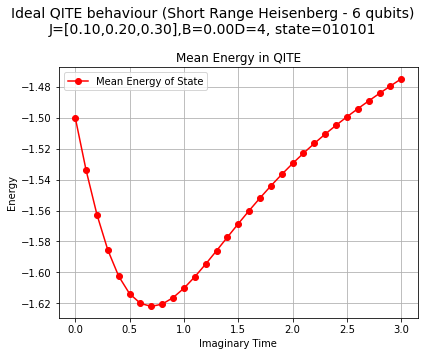

In [69]:
# QITE Parameters
db = 0.1       # Size of imaginary time step
N = 30          # Number of imaginary time steps
shots = 1000    # Number of measurements taken for each circuit
delta = 0.1     # Regularizer value

# Set true if using 2nd order trotterization
_2nd_ord_flag = True

# Hamiltonian Description
nbits = 6       # Number of qubits in the full system
J = [0.1,0.2,0.3]
B = 0
hm_list = short_range_heisenberg(nbits, J, B)

w,v = get_spectrum(hm_list,nbits)

h_name = 'Short Range Heisenberg - {} qubits'.format(nbits)
prob_string = 'J=[{:0.2f},{:0.2f},{:0.2f}],B={:0.2f}'.format(J[0],J[1],J[2],B)

log_path = './qite_logs/ideal_qite{}/{}/db={:0.1f}/N={}/'.format('_2nd_ord' if _2nd_ord_flag else '',h_name,db,N)
fig_path = './figs/ideal_qite{}/{}/db={:0.1f}/N={}/'.format('_2nd_ord' if _2nd_ord_flag else '',h_name,db,N)

if not(path.exists(log_path)):
    makedirs(log_path)
if not(path.exists(fig_path)):
    makedirs(fig_path)


state_label = '01'*(nbits//2)
for D in [2,4,6]:
    print('******Iteration D={}:******'.format(D))
    id_string = prob_string+'D={}, state={}'.format(D,state_label)
    log_file = log_path + id_string
    fig_file = fig_path + id_string

    init_sv = Statevector.from_label(state_label)
    E,times,states = ideal_qite_ext_domain(db,delta,N,nbits,hm_list,D,init_sv,details=True,log=True,log_file=log_file)
    plot_data(E,states, id_string, fig_file, prob_flag=False)